# ADER-FD

This notebook demonstrates the implementation of a finite-difference scheme for solving the first-order formulation of the acoustic wave equation using ADER (Arbitrary-order-accuracy via DERivatives) time integration. This enables a temporal discretisation up the order of the spatial discretisation, whilst preventing the grid-grid decoupling (often referred to as checkerboarding) associated with solving first-order systems of equations on a single finite-difference grid.

The method is detailed in "Fast High Order ADER Schemes for Linear Hyperbolic Equations" by Schwartzkopf et al. (https://doi.org/10.1016/j.jcp.2003.12.007).

Defining the state vector as

$\mathbf{U} = \begin{bmatrix} p \\ \mathbf{v} \end{bmatrix}$,

and taking a Taylor-series expansion of $\mathbf{U}(t+\Delta t)$ at time $t$, one obtains

$\mathbf{U}(t+\Delta t) = \mathbf{U}(t) + \frac{\partial \mathbf{U}}{\partial t}(t) + \frac{1}{2}\frac{\partial^2 \mathbf{U}}{\partial t^2}(t) + \frac{1}{6}\frac{\partial^3 \mathbf{U}}{\partial t^3}(t) + \dots$.

Using the governing equations

$\frac{\partial \mathbf{U}}{\partial t} = \begin{bmatrix}\rho c^2 \boldsymbol{\nabla}\cdot\mathbf{v} \\ \frac{1}{\rho}\boldsymbol{\nabla}p \end{bmatrix}$,

one can derive expressions for these higher-order time derivatives in terms of spatial derivatives. High-order explicit timestepping is achieved by substituting these expressions into the Taylor expansion, truncated at the temporal discretisation order one intends to achieve. As such, the order of the temporal discretisation can be increased to that of the spatial discretisation.

In [1]:
import devito as dv
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

from examples.seismic import TimeAxis, RickerSource

To begin, we set up the `Grid` as usual. Note that no staggering is specified for the `Function`s as it is not needed in this case.

In [2]:
grid = dv.Grid(shape=(201, 201), extent=(1000., 1000.))
p = dv.TimeFunction(name='p', grid=grid, space_order=16)
v = dv.VectorTimeFunction(name='v', grid=grid, space_order=16, staggered=(None, None))

Material parameters are specified as in the conventional case. Note that if one assumes non-constant material parameters when deriving the higher time derivatives, it will be necessary to increase the `space_order` of these functions, and values may need extending into the halo using the  `data_with_halo` view.

In [3]:
# Material parameters
c = dv.Function(name='c', grid=grid)
rho = dv.Function(name='rho', grid=grid)

c.data[:] = 1.5
c.data[:, :150] = 1.25
c.data[:, :100] = 1.
c.data[:, :50] = 0.75

rho.data[:] = c.data[:]

# Define bouyancy for shorthand
b = 1/rho
# Define celerity shorthands
c2 = c**2
c4 = c**4

Now we will specify each of the temporal derivatives required for a 4th-order ADER timestepping scheme. Note that for conciseness, the derivations assume constant material parameters.

In [4]:
# dv.grad(dv.div(v)) is not the same as expanding the continuous operator and then discretising
# This is because dv.grad(dv.div(v)) applies a gradient stencil to a divergence stencil
def graddiv(f):
    return sp.Matrix([[f[0].dx2 + f[1].dxdy],
                      [f[0].dxdy + f[1].dy2]])

def lapdiv(f):
    return f[0].dx3 + f[0].dxdy2 + f[1].dx2dy + f[1].dy3

def gradlap(f):
    return sp.Matrix([[f.dx3 + f.dxdy2],
                      [f.dx2dy + f.dy3]])

def gradlapdiv(f):
    return sp.Matrix([[f[0].dx4 + f[0].dx2dy2 + f[1].dx3dy + f[1].dxdy3],
                      [f[0].dx3dy + f[0].dxdy3 + f[1].dx2dy2 + f[1].dy4]])\

def biharmonic(f):
    return f.dx4 + 2*f.dx2dy2 + f.dy4

# First time derivatives
pdt = rho*c2*dv.div(v)
vdt = b*dv.grad(p)

# Second time derivatives
pdt2 = c2*p.laplace
vdt2 = c2*graddiv(v)

# Third time derivatives
pdt3 = rho*c4*lapdiv(v)
vdt3 = c2*b*gradlap(p)

# Fourth time derivatives
pdt4 = c4*biharmonic(p)
vdt4 = c4*gradlapdiv(v)

Define the model timestep.

In [5]:
# Model timestep
op_dt = 0.8*np.amin(grid.spacing)/np.amax(c.data)  # Courant number of 0.8

Now define the update equations for 4th-order ADER timestepping.

In [6]:
dt = grid.stepping_dim.spacing

# Update equations (2nd-order ADER timestepping)
# eq_p = dv.Eq(p.forward, p + dt*pdt + (dt**2/2)*pdt2)
# eq_v = dv.Eq(v.forward, v + dt*vdt + (dt**2/2)*vdt2)

# Update equations (3rd-order ADER timestepping)
# eq_p = dv.Eq(p.forward, p + dt*pdt + (dt**2/2)*pdt2 + (dt**3/6)*pdt3)
# eq_v = dv.Eq(v.forward, v + dt*vdt + (dt**2/2)*vdt2 + (dt**3/6)*vdt3)

# Update equations (4th-order ADER timestepping)
eq_p = dv.Eq(p.forward, p + dt*pdt + (dt**2/2)*pdt2 + (dt**3/6)*pdt3 + (dt**4/24)*pdt4)
eq_v = dv.Eq(v.forward, v + dt*vdt + (dt**2/2)*vdt2 + (dt**3/6)*vdt3 + (dt**4/24)*vdt4)

Add a source.

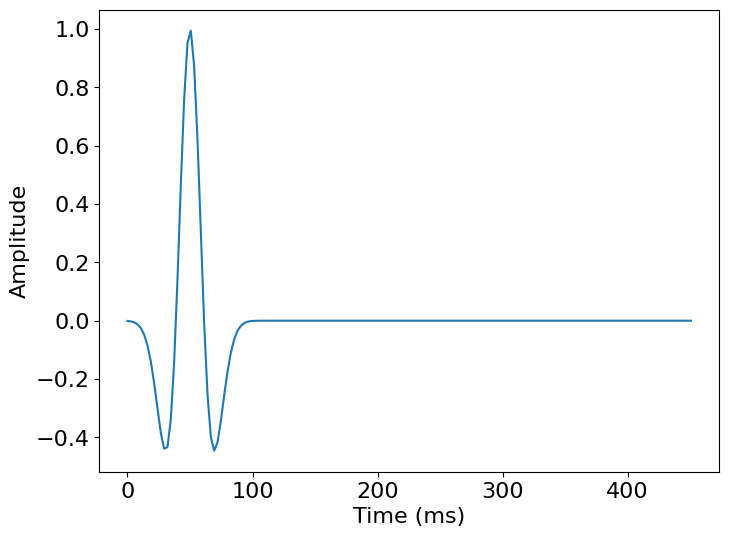

In [7]:
t0 = 0.  # Simulation starts a t=0
tn = 450.  # Simulation last 0.45 seconds (450 ms)

time_range = TimeAxis(start=t0, stop=tn, step=op_dt)

f0 = 0.020  # Source peak frequency is 20Hz (0.020 kHz)
src = RickerSource(name='src', grid=grid, f0=f0,
                   npoint=1, time_range=time_range)

# Position source centrally in all dimensions
src.coordinates.data[0, :] = np.array(grid.extent) * .5

# We can plot the time signature to see the wavelet
src.show()

Finally we can run our propagator.

In [8]:
src_term = src.inject(field=p.forward, expr=src)

op = dv.Operator([eq_p, eq_v] + src_term)
op.apply(dt=op_dt)

Operator `Kernel` ran in 0.05 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.03385899999999996, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.010494999999999999, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

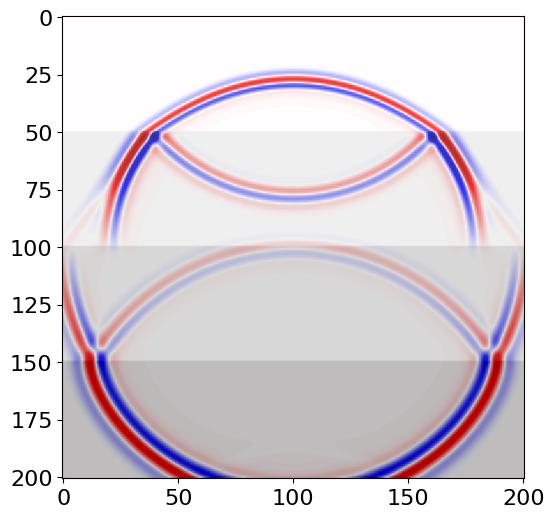

In [9]:
plt.imshow(c.data.T, cmap='Greys')
plt.imshow(p.data[-1].T, cmap='seismic', alpha=0.75)
plt.show()